# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import binarize
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict
from scipy.ndimage.filters import convolve, sobel
from IPython.display import display, HTML
from scipy.sparse import csr
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

# Display centered pandas tables
def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])

# Plot formats
from cycler import cycler
import matplotlib.patches as patches
import matplotlib.mlab as mlab
import matplotlib.dates
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# Set the randomizer seed so results are the same each time ... Reproducibility
np.random.seed(0)

### I used the train data for all analyses, bar P2

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_openml('mnist_784', version=1, data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


## (1) 

Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

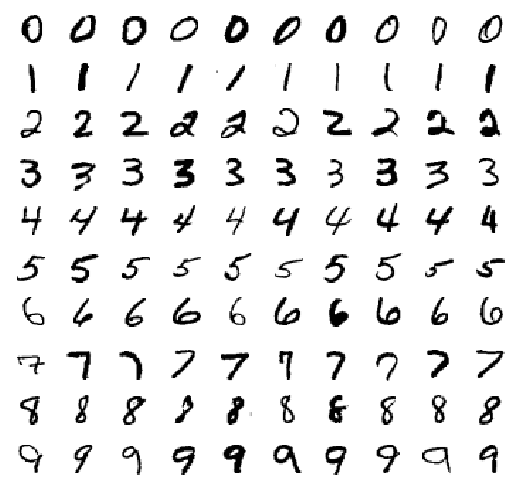

In [3]:
def P1(num_examples=10):
    """ 
    1st Problem. Create a grid 10x10 to visualize each digit
    Args:
        Number of examples we want to run. Current default value num_examples = 10 (number of columns)
    Returns:
        Grid 10x10 of the digit. Print it in console, no return value
    """
    rows,cols = 10, num_examples
    size = 28
    fig,ax = plt.subplots(rows,cols,figsize=(8,8), frameon=False)
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(X[Y==str(i)][j].reshape((28,28)), vmin=0, vmax=1, cmap=plt.cm.gray_r, interpolation="nearest")
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].grid('off')
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
                    
                    
P1(10)

## (2) 
Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):
    """ 
    2nd Problem. Train a K-Nearest Neighbors classifier with several k
    Args:
        Vector of K's.
    Returns:
        Accuracy on the development set, printed in console. If k=1, also return precision, recall, F1
    """
    
    for k in k_values:
        knn_clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        
        # Dictionary for storing accuracy
        acc = dict()
        for i in range(10):
            # Create a label for the ith digit, we are training a classifier for each digit
            mini_train_labels_i = (mini_train_labels == str(i))
            
            # Fit the model
            knn_clf.fit(mini_train_data, mini_train_labels_i)
            
            # Test in development set, using cross validation cv = 3
            dev_labels_i = (dev_labels == str(i))
            y_dev_pred = knn_clf.predict(dev_data)
            acc[i] = accuracy_score(dev_labels_i, y_dev_pred)
        
        # Print in console the results
        print('Value for k = %d'%k)
        if k == 1:
            print("Classification report: Precision, Recall, and F1 score")
            knn_clf.fit(mini_train_data, mini_train_labels)
            y_dev_pred = knn_clf.predict(dev_data)
            print(classification_report(dev_labels, y_dev_pred))
        print('Accuracy per digit')
        a = pd.DataFrame.from_dict(acc, orient='index')
        a.index.name = 'Digit'
        a.rename(columns = {0:'Accuracy'}, inplace=True)
        display(a.T)

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Value for k = 1
Classification report: Precision, Recall, and F1 score
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

Accuracy per digit


Digit,0,1,2,3,4,5,6,7,8,9
Accuracy,0.99,0.983,0.969,0.981,0.978,0.976,0.984,0.977,0.963,0.967


Value for k = 3
Accuracy per digit


Digit,0,1,2,3,4,5,6,7,8,9
Accuracy,0.991,0.982,0.97,0.981,0.978,0.982,0.983,0.978,0.964,0.966


Value for k = 5
Accuracy per digit


Digit,0,1,2,3,4,5,6,7,8,9
Accuracy,0.991,0.982,0.966,0.978,0.98,0.986,0.985,0.977,0.962,0.975


Value for k = 7
Accuracy per digit


Digit,0,1,2,3,4,5,6,7,8,9
Accuracy,0.989,0.982,0.965,0.977,0.977,0.982,0.985,0.974,0.963,0.97


Value for k = 9
Accuracy per digit


Digit,0,1,2,3,4,5,6,7,8,9
Accuracy,0.988,0.979,0.961,0.974,0.974,0.981,0.985,0.976,0.963,0.969


### Answer:

As we can observe,we get strong accuracy values accross all digits. As an interesting result, accuracy seems to go down when we increase the number of neighbors. Is important to highlight that for each digit we are calculating a kNN classifier on its own, adapted to labels equal to that digit.

The most difficult digit overall is 8, although 9 and 2 are also on the "low tier". 

## (3) 
Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):
    """ 
    3rd Problem. Train a k = 1 Nearest Neighbor Classifier for different trining set sizes
    Args:
        Vector of train_sizes, empty list of accuracies
    Returns:
        List of accuracies of the development set.
    """
    
    for t in train_sizes:
        # Create classifier Object
        knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
        
        # Start timer, for prediction I switch to standard prediction
        start = time.time()
        knn_clf.fit(train_data[:t], train_labels[:t])
        y_dev_pred = knn_clf.predict(dev_data)
        
        # End timer
        end = time.time()
        
        # Return accuracies
        accuracies.append(accuracy_score(dev_labels, y_dev_pred))
        print("For training size of %d, time for prediction is %.2f seconds"%(t,end-start))
    return accuracies
        

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For training size of 100, time for prediction is 0.20 seconds
For training size of 200, time for prediction is 0.19 seconds
For training size of 400, time for prediction is 0.14 seconds
For training size of 800, time for prediction is 0.26 seconds
For training size of 1600, time for prediction is 0.59 seconds
For training size of 3200, time for prediction is 1.14 seconds
For training size of 6400, time for prediction is 2.23 seconds
For training size of 12800, time for prediction is 4.74 seconds
For training size of 25000, time for prediction is 10.43 seconds


[0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.962]

## (4) 
Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

The prediction for n = 60,000 is 1.2447
The prediction for n = log(60,000) is 1.0337
The prediction for n = 1/log(60,000) is 0.9902


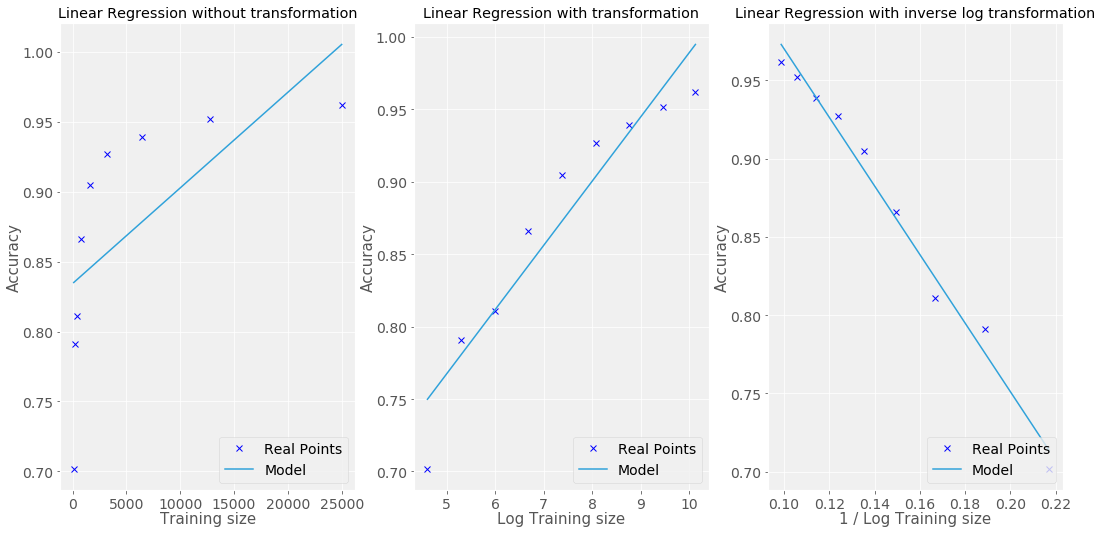

In [6]:
def P4():
    """ 
    4th Problem. Fit a regression line to predict accuracy from training size
    Args:
        No arguments. We use the same variables in the global environtment train_sizes and accuracies
    Returns:
        Plot of the linear regression, plot of the transformed regression, prediction for n = 60000 for both models
    """
    # Define the variables for the regression
    X = np.array(train_sizes).reshape(-1, 1) 
    y = np.array(accuracies)
    n = np.array([60000]).reshape(-1,1)
    
    # Define the transformation. Because of how the X variable is increasing exponentially, let's do a log transformation
    X_log = np.log(X)
    n_log = np.log(n)
    X_1_log = 1/X_log
    n_1_log = 1/n_log
    
    # Fit a regression line
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    y_pred = lin_reg.predict(X)
    
    # Plot the regression
    fig = plt.figure(figsize=(16,8))
    mpl.rcParams['figure.figsize'] = 16,8
    ax = fig.add_subplot(1,3,1)
    ax.plot(X, y, 'bx')
    plt.title("Linear Regression without transformation")
    ax.plot(X, y_pred)
    ax.legend(['Real Points','Model'], loc='lower right')
    ax.set_xlabel('Training size')
    ax.set_ylabel('Accuracy')
    print("The prediction for n = 60,000 is %.4f"%lin_reg.predict(n))
    
    # Fit a regression to a log transformation
    lin_reg = LinearRegression()
    lin_reg.fit(X_log, y)
    y_pred = lin_reg.predict(X_log)
    
    # Plot the log regression
    ax = fig.add_subplot(1,3,2)
    ax.plot(X_log, y, 'bx')
    plt.title("Linear Regression with transformation")
    ax.plot(X_log, y_pred)
    ax.legend(['Real Points','Model'], loc='lower right')
    ax.set_xlabel('Log Training size')
    ax.set_ylabel('Accuracy')
    print("The prediction for n = log(60,000) is %.4f"%lin_reg.predict(n_log))
    
    # Fit an inverse log Transformation
    lin_reg = LinearRegression()
    lin_reg.fit(X_1_log, y)
    y_pred = lin_reg.predict(X_1_log)    
    
    # Plot the inverse log regression
    ax = fig.add_subplot(1,3,3)
    ax.plot(X_1_log, y, 'bx')
    plt.title("Linear Regression with inverse log transformation")
    ax.plot(X_1_log, y_pred)
    ax.legend(['Real Points','Model'], loc='lower right')
    ax.set_xlabel('1 / Log Training size')
    ax.set_ylabel('Accuracy')
    print("The prediction for n = 1/log(60,000) is %.4f"%lin_reg.predict(n_1_log))

P4()

### Answer:

The first plot, is regressing Accuracy over Training Size. As expected, the data points are for linear (the domain of X is increasing like an exponential), thus this is not a good model for try to predict accuracy on the train set. Also, by definition accuracy is capped at 1; this type of boundary doesn't bode well with linear models. Finally, we should use the predicted values of a linear regression inside the domain that we used for training it (in our case $200 < n < 25000$), extrapolating is not recommended.

However, if we want to fit this model, the domain screams to use a log transformation on X. Using this approach, we get a better model (visually at least). Nevertheless, the rules of extrapolation still applies and we predict an accuracy level greater than 1, still impossible, but closer to the theoretical limit than the linear model prediction

Finally, we could try an inverse (reciprocal) log regression, knowing that the data has an hyperbolic asymptote. In this case, the regression won't be higher than 1, which is what we need. In this case, the prediction of accuracy is close to 99%. Nevertheless, we are still extrapolating, which is not recommended at any case when using linear regression.


## (5) 
Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [7]:
# Function for plotting n digits
def plot_digits(data, images_per_row=10):
    size = 28
    images_per_row = min(len(data), images_per_row)
    images = [instance.reshape(size,size) for instance in data]
    n_rows = (len(data)-1)//images_per_row + 1
    row_images = []
    n_empty = n_rows*images_per_row-len(data)
    images.append(np.zeros((size, size*n_empty)))
    for row in range(n_rows):
        rimages = images[row*images_per_row : (row + 1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary)
    plt.axis("off")

Confusion Matrix
[[105   1   0   0   0   0   0   0   0   0]
 [  0 117   0   0   0   0   0   0   1   0]
 [  1   0 102   0   0   0   0   2   1   0]
 [  0   1   0  92   0   2   0   1   1   0]
 [  0   0   0   0  92   0   0   0   0   0]
 [  1   0   0   2   0  83   1   0   0   1]
 [  0   0   0   0   0   1 100   0   1   0]
 [  0   0   1   0   0   0   0 101   0   0]
 [  1   1   2   2   1   0   2   0  85   0]
 [  0   0   0   0   1   0   0   0   0  94]]

Most confused digits are 3 and 5

In the following plots, on the top left and bottom right we have correct predictions
the top right and bottom left are the confused ones



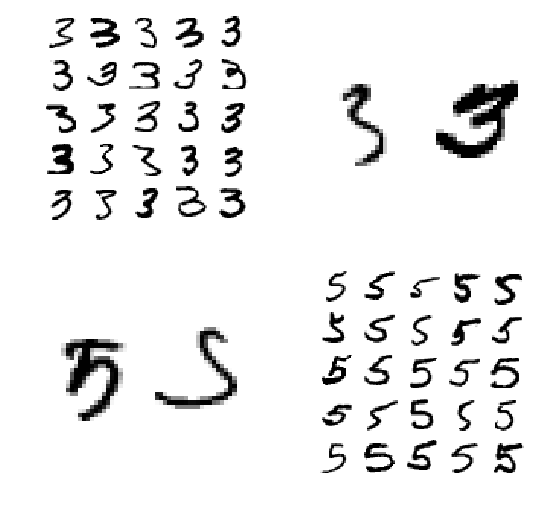

In [8]:
def P5():
    """ 
    5th Problem. Fit a 1-NN classifier and return the confusion matrix of dev data
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        Print confusion matrix. In console it will print the most confused pair of digits and show examples of the mistake
    """
    # Create classifier Object and fit using all the train data
    knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_clf.fit(train_data, train_labels)
    
    # Create predictions using development data
    y_dev_pred = knn_clf.predict(dev_data)
    
    # Return confusion matrix
    conf_mat = np.matrix(confusion_matrix(dev_labels, y_dev_pred))
    print('Confusion Matrix')
    print(conf_mat)
    
    # Find out the most confused digits
    good_prediction = np.zeros((10,10))
    np.fill_diagonal(good_prediction, np.diag(conf_mat))
    confused = (conf_mat - good_prediction)+(conf_mat - good_prediction).T
    max_confused = np.unravel_index(confused.argmax(), confused.shape)
    print('')
    print("Most confused digits are %d and %d"%(max_confused[0], max_confused[1]))
    print('')
    
    # Find examples of confusion and plot them
    print("In the following plots, on the top left and bottom right we have correct predictions")
    print("the top right and bottom left are the confused ones")
    print('')
    X_m1m1 = dev_data[(dev_labels == str(max_confused[0])) & (y_dev_pred == str(max_confused[0]))]
    X_m1m2 = dev_data[(dev_labels == str(max_confused[0])) & (y_dev_pred == str(max_confused[1]))]
    X_m2m1 = dev_data[(dev_labels == str(max_confused[1])) & (y_dev_pred == str(max_confused[0]))]
    X_m2m2 = dev_data[(dev_labels == str(max_confused[1])) & (y_dev_pred == str(max_confused[1]))]
    
    ## Plots
    plt.figure(figsize=(8,8))
    plt.subplot(221), plot_digits(X_m1m1[:25], 5)
    plt.subplot(222), plot_digits(X_m1m2[:25], 5)
    plt.subplot(223), plot_digits(X_m2m1[:25], 5)
    plt.subplot(224), plot_digits(X_m2m2[:25], 5)
    plt.show()
    
P5()

## (6) 
A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [9]:
# Data preprocessing by blurring
# Scipy version should be higher than 1.1.0

def blur(dataset, kernel, size_pixel = 28):
    """
    Function for blurring data using any given kernel
    Args:
        Dataset, kernel as a matrix, pixel size
    Returns:
        New blurred dataset
    """
    # Blurred data
    blur = np.zeros_like(dataset)
    
    # Data is blurred by rolling multiplication over the dataset
    for n, data in enumerate(dataset):
        reshaped = data.reshape((size_pixel,size_pixel))
        blurred = convolve(reshaped, kernel)
        blur[n] = blurred.ravel()
    return blur

Gauss_kernel = (1/16)*np.matrix([[1,2,1],[2,4,2],[1,2,1]])
start = time.time()
blur_train = blur(train_data, Gauss_kernel)
blur_dev = blur(dev_data, Gauss_kernel)
end = time.time()
print('Time of blurring data is %.2f seconds'%(end-start))

Time of blurring data is 2.17 seconds


In [10]:
def P6():
    """ 
    6th Problem. Implement a simplified Gaussian blur, and then fit a 1-NN Classifier
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        Print accuracy score of baseline (original), blurred training data, blurred development, and both blurred.
    """
    
    # Fit model baseline (original data)
    knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_clf.fit(train_data, train_labels)
    y_dev_pred = knn_clf.predict(dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of 1-NN Classifier using original training and original development data is %.3f"%a)
    
    # Preprocessed training
    knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_clf.fit(blur_train, train_labels)
    y_dev_pred = knn_clf.predict(dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of 1-NN Classifier using blurred training and original development data is %.3f"%a)
    
    # Preprocessed development data
    knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_clf.fit(train_data, train_labels)
    y_dev_pred = knn_clf.predict(blur_dev)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of 1-NN Classifier using original training and blurred development data is %.3f"%a) 
    
    # Preprocessed training and development data
    knn_clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_clf.fit(blur_train, train_labels)
    y_dev_pred = knn_clf.predict(blur_dev)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of 1-NN Classifier using blurred training and blurred development data is %.3f"%a) 
    

P6()

The accuracy of 1-NN Classifier using original training and original development data is 0.971
The accuracy of 1-NN Classifier using blurred training and original development data is 0.974
The accuracy of 1-NN Classifier using original training and blurred development data is 0.974
The accuracy of 1-NN Classifier using blurred training and blurred development data is 0.978


### Answer:
As printed by the function, there is an improvement in accuracy by using blurred data. Interestingly, you can blurred only the development data and get the same result as if you blurred the whole training set. With both blurred datasets, we get the best performance.

As a sidenote, in terms of scability, the blurring process is quite an expensive process, although it can be vectorized by the convolve function in scipy, for only an increase of 0.3% of accuracy. If I have to choose, I will only blurred the test data, to avoid this time cost. 

## (7) 
Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [11]:
def P7():
    """ 
    7th Problem. Fit a Naive Bayes classifier and return accuracies, using binary values and (0,1,2) values
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        Prints in console the accuracy of a Naive Bayes classifier
    """
    # Preprocess the data, using sparce matrices
    sp_train_data = csr.csr_matrix(train_data)
    sp_dev_data = csr.csr_matrix(dev_data)
    nb_bin_clf = Pipeline([
        ('binary',Binarizer()), 
        ('bin_clf',BernoulliNB())])
    nb_bin_clf.fit(sp_train_data, train_labels)
    y_dev_pred = nb_bin_clf.predict(sp_dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of a Bernoulli Naive Bayes Classifier is %.3f"%a)
    
    # Fit a Multinomial NB
    multi_train_data = np.array(train_data)
    multi_train_data[(multi_train_data>0) & (multi_train_data<0.5)] = 1
    multi_train_data[(multi_train_data>0.5) & (multi_train_data<1)] = 2
    multi_dev_data = np.array(dev_data)
    multi_dev_data[(multi_dev_data>0) & (multi_dev_data<0.5)] = 1
    multi_dev_data[(multi_dev_data>0.5) & (multi_dev_data<1)] = 2
    nb_multi_clf = MultinomialNB()
    nb_multi_clf.fit(multi_train_data, train_labels)
    y_dev_pred = nb_multi_clf.predict(multi_dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of a Multinomial (0,1,2) Naive Bayes Classifier is %.3f"%a)
    
P7()

The accuracy of a Bernoulli Naive Bayes Classifier is 0.828
The accuracy of a Multinomial (0,1,2) Naive Bayes Classifier is 0.812


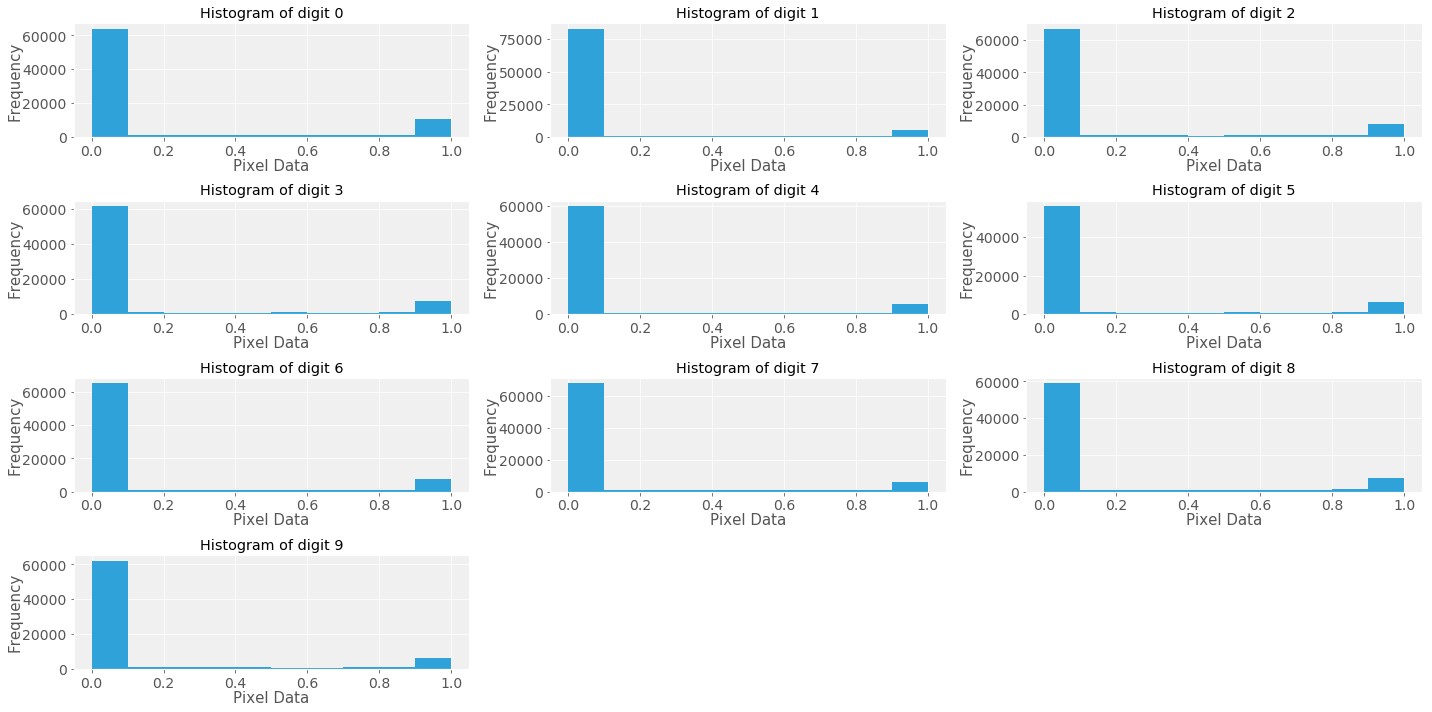

In [12]:
# Histogram of the development data, for each digit
fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax = fig.add_subplot(4,3,i+1)
    new_data = pd.DataFrame(np.ravel(dev_data[dev_labels == str(i)]))
    ax.hist(new_data)
    ax.set_title("Histogram of digit %d"%i)
    ax.set_xlabel('Pixel Data')
    ax.set_ylabel('Frequency')
fig.tight_layout()


### Answer:

I plotted all the histograms of each digit in the development data set to try tu understand the underlying distribution. As observed, a Binomial distribution binarize around 0 seems to be adecuated, because the majority of the mass is located in 0 or 1. This is the main reason the Bernouill NB has better accuracy than the Multinomial NB. 

## (8) 
Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [13]:
def P8(alphas):
    """ 
    8th Problem. Perform a GridSearchCV with Laplace smoothing in a Bernoulli NB
    Args:
        Dictionary of alphas. Rest of variables are global
    Returns:
        Return the best value of alpha for a Bernoulli NB
    """
    # Fit a Bernoulli NB
    sp_train_data = csr.csr_matrix(train_data)
    sp_dev_data = csr.csr_matrix(dev_data)
    nb_bin_clf = BernoulliNB()
    param_grid = {
        'alpha': alphas['alpha']}
    best_nb_clf = GridSearchCV(nb_bin_clf,param_grid,scoring='accuracy')
    best_nb_clf.fit(sp_train_data, train_labels)
    results = pd.DataFrame(best_nb_clf.cv_results_,index = alphas['alpha'])
    results.index.name = 'alphas'
    
    # Print accuracies, in a centered table

    display(pd_centered(results[['mean_test_score','mean_train_score']]))
    return best_nb_clf
    
    

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print(nb.best_params_)

,mean_test_score,mean_train_score
alphas,,
0.0,0.833367,0.835667
0.0001,0.833267,0.835133
0.001,0.8331,0.834933
0.01,0.832983,0.834583
0.1,0.832767,0.834225
0.5,0.832567,0.833842
1.0,0.8323,0.833533
2.0,0.831933,0.832942
10.0,0.8302,0.831067


{'alpha': 0.0}


### Answer:

In the full training set, an alpha of 0 (no smoothing) produces the best accuracy in the train or test data of the cross validation. The reason for this, is that the distribution for 0 and 1 is quite high for all digits, and almost in the middle is close to zero, thus the smoothing actually moves you away from the "real" distribution of the data. 

However, the differences are quite narrow even when going to a smoothing factor of 10. This means that the Bernouilli distribution around 0 and 1 seems quite appropiate.

## (9) 
Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [14]:
def P9():
    """ 
    9th Problem. Fit a GaussianNB classifier and compare it to a GaussianNB with a fix
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        Prints in console the accuracy of a Naive Bayes classifier
    """
    # Fit a regular GaussianNB, without any 'fix'
    nb_gauss_clf = GaussianNB()
    nb_gauss_clf.fit(train_data, train_labels)
    y_dev_pred = nb_gauss_clf.predict(dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of a Gaussian Naive Bayes Classifier is %.3f"%a)
    
    # Add noise to training data
    noise_train_data = train_data + np.random.normal(0,0.1,(60000,784))
    nb_gauss_clf.fit(noise_train_data, train_labels)
    y_dev_pred = nb_gauss_clf.predict(dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of a Gaussian Naive Bayes Classifier using noisy data is %.3f"%a)
    
    # Changing the variance tolerance
    nb_gauss_clf = GaussianNB(var_smoothing=0.05)
    nb_gauss_clf.fit(train_data, train_labels)
    y_dev_pred = nb_gauss_clf.predict(dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of a Gaussian Naive Bayes Classifier using sigma smoothing threshold as 0.05 is %.3f"%a)
    
    # Using both techniques
    nb_gauss_clf.fit(noise_train_data, train_labels)
    y_dev_pred = nb_gauss_clf.predict(dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of a Gaussian Naive Bayes Classifier using both noisy data and variance smoothing is %.3f"%a)
    return nb_gauss_clf

gnb = P9()

The accuracy of a Gaussian Naive Bayes Classifier is 0.586
The accuracy of a Gaussian Naive Bayes Classifier using noisy data is 0.814
The accuracy of a Gaussian Naive Bayes Classifier using sigma smoothing threshold as 0.05 is 0.814
The accuracy of a Gaussian Naive Bayes Classifier using both noisy data and variance smoothing is 0.808


In [20]:
# Find the best var-smoothing parameter for the classifier
nb_gauss_clf = GaussianNB(var_smoothing=0.05)
param_grid = {
        'var_smoothing': [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.5,1]}
best_nb_clf = GridSearchCV(nb_gauss_clf,param_grid,scoring='accuracy')
best_nb_clf.fit(train_data, train_labels)
results = pd.DataFrame(best_nb_clf.cv_results_)

In [16]:
results.index = [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.5,1]
results.index.name = 'var-smoothing'
display(pd_centered(results[['mean_test_score','mean_train_score']]))
print(best_nb_clf.best_params_)

,mean_test_score,mean_train_score
var-smoothing,,
0.0,0.0989167,0.0989167
0.01,0.783817,0.785392
0.02,0.7942,0.795542
0.03,0.799383,0.800775
0.04,0.801633,0.803708
0.05,0.803533,0.805208
0.06,0.804433,0.805358
0.07,0.804917,0.80575
0.08,0.80485,0.805717


{'var_smoothing': 0.07}


### Answer:

 I did a var_smoothing Grid Search to convince myself that we need to avoid an around 0 variance for a Gaussian NB. As we have seen with the histograms, the variance of the distribution is high (lots of mass around 0 and 1, away for a possible mean). That's why changing the variance helps the accuracy of the models.
 
 We can introduce variance to the data by adjusting the var parameter or by adding noise to the data, and increase the variance. As we can see, we have accuracies closer to the Bernouilli NB with either adding noisy data or changing the parameter, but not both.

## (10) 
Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

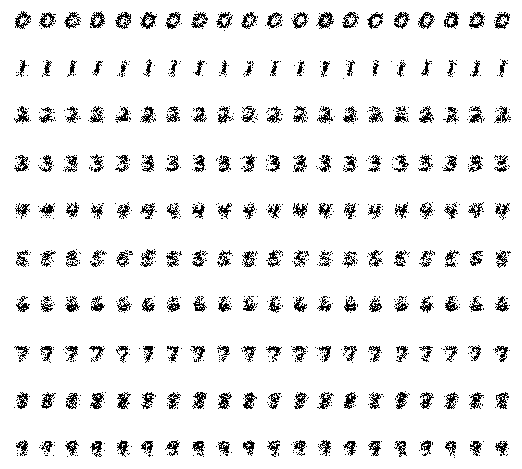

In [17]:
def P10(num_examples):
    """ 
    10th Problem. Generate BernoulliNB digits
    Args:
        An integer with the total number of examples. All data is loaded in the global environment
    Returns:
        Print a 10x20 grid for each digit in console
    """
    # Train a BernoulliNB Classifier as Problem 7
    sp_train_data = csr.csr_matrix(train_data)
    sp_dev_data = csr.csr_matrix(dev_data)
    nb_bin_clf = Pipeline([
        ('binary',Binarizer()), 
        ('bin_clf',BernoulliNB())])
    nb_bin_clf.fit(sp_train_data, train_labels)
    
    # Print 10x20 examples using the model
    fig,ax = plt.subplots(10,num_examples,figsize=(8,8), frameon=False)
    for i in range(10):
        for j in range(num_examples):
            mat = np.exp(nb_bin_clf.named_steps['bin_clf'].feature_log_prob_[i])
            
            # Create a random vector size 784, and then check directly with the matrix of probabilities
            n = np.random.rand(784)
            mat = (mat>n).astype(int)
            ax[i,j].imshow(mat.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest")
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].grid('off')
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)

P10(20)

### Answer:

We obtain some readable digits by using this generative models. Is clear in each plot which digit is being created by the model. However, we still have some issues with the digit 8 and with 3 and 5.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [18]:
def P11(buckets, correct, total):
    """ 
    11th Problem. Test the calibration a Bernoulli Naive Bayes Classifier
    Args:
        An array of buckets, two arrays initialized as 0 named correct and total, which will be updated. 
    Returns:
        Updated correct and total lists with total accuracy per bucket
    """    
    # Train a BernoulliNB using alpha = 0, as we find out in Problem 8
    sp_train_data = csr.csr_matrix(train_data)
    sp_dev_data = csr.csr_matrix(dev_data)
    nb_bin_clf = Pipeline([
        ('binary',Binarizer()), 
        ('bin_clf',BernoulliNB(alpha=0.0))])
    nb_bin_clf.fit(sp_train_data, train_labels)
    
    # Get the max posteriori probability for each prediction and calculate each prediction
    prob_pred = np.max(nb_bin_clf.named_steps['bin_clf'].predict_proba(sp_dev_data), axis=1)
    y_dev_pred = nb_bin_clf.predict(sp_dev_data)
    
    # Update each list of correct and total. Transverse the histogram bins
    low_int = 0.0
    i = 0
    for b in buckets:
        bin_match =np.logical_and(prob_pred>low_int, prob_pred<=b)
        total[i] = np.sum(bin_match)
        correct[i] = np.sum(dev_labels[bin_match] == y_dev_pred[bin_match])
        low_int = b
        i+=1

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  34    accuracy = 0.412
p(pred) <= 0.9990000000000    total =  64    accuracy = 0.500
p(pred) <= 0.9999900000000    total =  57    accuracy = 0.579
p(pred) <= 0.9999999000000    total =  43    accuracy = 0.605
p(pred) <= 0.9999999990000    total =  50    accuracy = 0.660
p(pred) <= 0.9999999999900    total =  50    accuracy = 0.780
p(pred) <= 0.9999999999999    total =  65    accuracy = 0.738
p(pred) <= 1.0000000000000    total = 637    accuracy = 0.950


### Answer:

We can see that our classifier, using the best alpha found in P8, is weakly calibrated. While it exits correlation between the posteriori probability and the accuracy (it's a linear increasing function), the accuracy are not entirely 1 to 1. Therefore, this model is weakly calibrated

## (12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [19]:
# Add first feature. Noise will be added if classifier is Gaussian
def f1(data, clf):
    """ 
    Function for adding the 1st additional feature: Add sum of pixel rows and columns
    Args:
        Data set
    Returns:
        New data set with added feature
    """  
    if clf == 'g': new_data = np.array(data)+np.random.normal(0,0.1,(data.shape[0],784))
    if clf == 'b': new_data = np.array(data)
    f1_data = np.zeros((new_data.shape[0],new_data.shape[1]+28*2))
    for i in range(new_data.shape[0]):
        aux = new_data[i].reshape(28,28)
        rowS = np.sum(aux, axis=0)
        colS = np.sum(aux, axis=1)
        f1_data[i] = np.hstack((new_data[i], rowS, colS))
    return f1_data

# Add second feature
def f2(data, label, clf):
    """ 
    Function for adding the 2nd additional feature: Number of enclosed regions: 0 for 1,2,3,5,7; 1 for 0,4,6,9; 2 for 8
    Args:
        Data set
    Returns:
        New data set with added feature
    """ 
    if clf == 'g': new_data = np.array(data)+np.random.normal(0,0.1,(data.shape[0],784))
    if clf == 'b': new_data = np.array(data)
    f2_data = np.zeros((new_data.shape[0],new_data.shape[1]+1))
    enc_0 = ['1', '2', '3', '5', '7']
    enc_1 = ['0', '4', '6', '9']
    for i in range(new_data.shape[0]):
        if str(label[i]) in enc_0: f2_data[i] = np.hstack((new_data[i], 0))
        if str(label[i]) in enc_1: f2_data[i] = np.hstack((new_data[i], 1))
        else: f2_data[i] = np.hstack((new_data[i], 2))
    return f2_data

# Add third feature
def f3(data, clf):
    """ 
    Function for adding the 3rd additional feature: Add the Sobel filter of the direction and the edge of the digit
    Args:
        Data set
    Returns:
        New data set with added feature
    """ 
    if clf =='g': new_data = np.array(data)+np.random.normal(0,0.1,(data.shape[0],784))
    if clf == 'b': new_data = np.array(data)
    f3_data = np.zeros((new_data.shape[0],new_data.shape[1]+784))
    for i in range(new_data.shape[0]):
        aux = sobel(new_data[i][:784])
        f3_data[i] = np.hstack((new_data[i], new_data[i][:784]-aux))
    return f3_data
    
# Add 4th feature
def f4(data, clf):
    """ 
    Function for adding the 4th additional feature: Sharpen Image
    Args:
        Data set
    Returns:
        New data set with added feature
    """ 
    if clf =='g': new_data = np.array(data)+np.random.normal(0,0.1,(data.shape[0],784))
    if clf == 'b': new_data = np.array(data)
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    f4_data = np.zeros((new_data.shape[0],new_data.shape[1]+784))
    for i in range(new_data.shape[0]):
        aux = new_data[i][:784].reshape(28,28)
        aux = convolve(aux,kernel)
        f4_data[i] = np.hstack((new_data[i], np.ravel(aux)))
    return f4_data
    

def P12():
    """ 
    12th Problem. Design new features to improve the performance of a Bernouilli NB Classifier
    Args:
        All data is loaded in the global environment
    Returns:
        Prints in console accuracy of each improvement, and 10 digits made by the generative model
    """  
    # Print the baseline result of Bernouill NB
    sp_train_data = csr.csr_matrix(train_data)
    sp_dev_data = csr.csr_matrix(dev_data)
    nb_bin_clf = Pipeline([
        ('binary',Binarizer()), 
        ('bin_clf',BernoulliNB())])
    nb_bin_clf.fit(sp_train_data, train_labels)
    y_dev_pred = nb_bin_clf.predict(sp_dev_data)
    a = accuracy_score(dev_labels, y_dev_pred)
    print("The accuracy of a Bernoulli Naive Bayes baseline is %.3f"%a)
    
    # Feature sum pixel values in each row and each column
    f1_train_b = f1(train_data,'b')
    f1_dev_b = f1(dev_data, 'b')
    f1_train_g = f1(train_data,'g')
    f1_dev_g = f1(dev_data, 'g')    
    sp_train_data = csr.csr_matrix(f1(train_data,'b'))
    sp_dev_data = csr.csr_matrix(f1(dev_data, 'b'))
    nb_bin_clf = Pipeline([
        ('binary',Binarizer()), 
        ('bin_clf',BernoulliNB(alpha=0.0))])
    nb_gauss_clf = GaussianNB(var_smoothing=0.07)
    nb_bin_clf.fit(sp_train_data, train_labels)
    nb_gauss_clf.fit(f1(train_data,'g'), train_labels)
    y_dev_pred_bnb = nb_bin_clf.predict(sp_dev_data)
    y_dev_pred_gnb = nb_gauss_clf.predict(f1(dev_data,'g'))
    a_bnb = accuracy_score(dev_labels, y_dev_pred_bnb)
    a_gnb = accuracy_score(dev_labels, y_dev_pred_gnb)
    print("The accuracy of a Bernoulli Naive Bayes Classifier - Feature 1 %.3f"%a_bnb)
    print("The accuracy of a Gaussian Naive Bayes Classifier - Feature 1 is %.3f"%a_gnb)
    
    # Feature number of enclosed regions
    f2_train_b = f2(train_data,train_labels,'b')
    f2_dev_b = f2(dev_data,dev_labels, 'b')
    f2_train_g = f2(train_data,train_labels,'g')
    f2_dev_g = f2(dev_data,dev_labels, 'g')     
    sp_train_data = csr.csr_matrix(f2(train_data,train_labels,'b'))
    sp_dev_data = csr.csr_matrix(f2(dev_data,dev_labels,'b'))
    nb_bin_clf.fit(sp_train_data, train_labels)
    nb_gauss_clf.fit(f2(train_data,train_labels,'g'), train_labels)
    y_dev_pred_bnb = nb_bin_clf.predict(sp_dev_data)
    y_dev_pred_gnb = nb_gauss_clf.predict(f2(dev_data,dev_labels,'g'))
    a_bnb = accuracy_score(dev_labels, y_dev_pred_bnb)
    a_gnb = accuracy_score(dev_labels, y_dev_pred_gnb)
    print("The accuracy of a Bernoulli Naive Bayes Classifier - Feature 2 is %.3f"%a_bnb)
    print("The accuracy of a Gaussian Naive Bayes Classifier - Feature 2 is %.3f"%a_gnb)
    
    # Add the Sobel filter of the image
    f3_train_b = f3(train_data,'b')
    f3_dev_b = f3(dev_data, 'b')
    f3_train_g = f3(train_data,'g')
    f3_dev_g = f3(dev_data, 'g')    
    sp_train_data = csr.csr_matrix(f3(train_data,'b'))
    sp_dev_data = csr.csr_matrix(f3(dev_data, 'b'))
    nb_bin_clf.fit(sp_train_data, train_labels)
    nb_gauss_clf.fit(f3_train_g, train_labels)
    y_dev_pred_bnb = nb_bin_clf.predict(sp_dev_data)
    y_dev_pred_gnb = nb_gauss_clf.predict(f3(dev_data, 'g'))
    a_bnb = accuracy_score(dev_labels, y_dev_pred_bnb)
    a_gnb = accuracy_score(dev_labels, y_dev_pred_gnb)
    print("The accuracy of a Bernoulli Naive Bayes Classifier - Feature 3 is %.3f"%a_bnb)
    print("The accuracy of a Gaussian Naive Bayes Classifier - Feature 3 is %.3f"%a_gnb)
    
    # Add the Sharpen filter of the image
    f4_train_b = f4(train_data,'b')
    f4_dev_b = f4(dev_data, 'b')
    f4_train_g = f4(train_data,'g')
    f4_dev_g = f4(dev_data, 'g')  
    sp_train_data = csr.csr_matrix(f4(train_data,'b'))
    sp_dev_data = csr.csr_matrix(f4(dev_data, 'b'))
    nb_bin_clf.fit(sp_train_data, train_labels)
    nb_gauss_clf.fit(f4(train_data,'g'), train_labels)
    y_dev_pred_bnb = nb_bin_clf.predict(sp_dev_data)
    y_dev_pred_gnb = nb_gauss_clf.predict(f4(dev_data, 'g'))
    a_bnb = accuracy_score(dev_labels, y_dev_pred_bnb)
    a_gnb = accuracy_score(dev_labels, y_dev_pred_gnb)
    print("The accuracy of a Bernoulli Naive Bayes Classifier - Feature 4 is %.3f"%a_bnb)
    print("The accuracy of a Gaussian Naive Bayes Classifier - Feature 4 is %.3f"%a_gnb)
    
    # Combine all features
    final_train_b = np.hstack((f1_train_b, f2_train_b[:,-1:], f3_train_b[:,-784:], f4_train_b[:,-784:]))
    final_train_g = np.hstack((f1_train_g, f2_train_g[:,-1:], f3_train_g[:,-784:], f4_train_g[:,-784:]))
    final_dev_b = np.hstack((f1_dev_b,f2_dev_b[:,-1:],f3_dev_b[:,-784:],f4_dev_b[:,-784:]))
    final_dev_g = np.hstack((f1_dev_g,f2_dev_g[:,-1:],f3_dev_g[:,-784:],f4_dev_g[:,-784:]))
    sp_train_data = csr.csr_matrix(final_train_b)
    sp_dev_data = csr.csr_matrix(final_dev_b)
    nb_bin_clf.fit(sp_train_data, train_labels)
    nb_gauss_clf.fit(final_train_g, train_labels)
    y_dev_pred_bnb = nb_bin_clf.predict(sp_dev_data)
    y_dev_pred_gnb = nb_gauss_clf.predict(final_dev_g)
    a_bnb = accuracy_score(dev_labels, y_dev_pred_bnb)
    a_gnb = accuracy_score(dev_labels, y_dev_pred_gnb)
    print("The accuracy of a Bernoulli Naive Bayes Classifier - All features combined is %.3f"%a_bnb)
    print("The accuracy of a Gaussian Naive Bayes Classifier - All features combined is %.3f"%a_gnb)    
    
    
P12()

The accuracy of a Bernoulli Naive Bayes baseline is 0.828
The accuracy of a Bernoulli Naive Bayes Classifier - Feature 1 0.834
The accuracy of a Gaussian Naive Bayes Classifier - Feature 1 is 0.757
The accuracy of a Bernoulli Naive Bayes Classifier - Feature 2 is 0.830
The accuracy of a Gaussian Naive Bayes Classifier - Feature 2 is 0.839
The accuracy of a Bernoulli Naive Bayes Classifier - Feature 3 is 0.830
The accuracy of a Gaussian Naive Bayes Classifier - Feature 3 is 0.821
The accuracy of a Bernoulli Naive Bayes Classifier - Feature 4 is 0.833
The accuracy of a Gaussian Naive Bayes Classifier - Feature 4 is 0.799
The accuracy of a Bernoulli Naive Bayes Classifier - All features combined is 0.835
The accuracy of a Gaussian Naive Bayes Classifier - All features combined is 0.745


### Answer:

I added as extra feature the edge of each image, using the Sobel Filter, and the convolve image using the Sharpening filter. Using each feature individually, there are improvements in either the Bernouilli NB or the Gaussian NB. 

Finally, if we combine all the features, we get better results with the Bernouilli NB. The individual feature with best result is using Gaussian NB with noisy data and the number of enclosed regions